In [1]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT, force_remount=True)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [2]:
%cd 'drive/My Drive/Workspaces/handwritten_character_recognition'

/content/drive/My Drive/Workspaces/handwritten_character_recognition


# 1. Data Preparation


## 1.1 Download Dataset from Kaggle



In [3]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d 'sachinpatel21/az-handwritten-alphabets-in-csv-format'

100% 185M/185M [00:01<00:00, 105MB/s]



In [6]:
! unzip  az-handwritten-alphabets-in-csv-format.zip

Archive:  az-handwritten-alphabets-in-csv-format.zip
  inflating: A_Z Handwritten Data.csv  
  inflating: A_Z Handwritten Data/A_Z Handwritten Data.csv  


## 1.2 Prepare

In [8]:
import pandas as pd

data_csv = pd.read_csv('data/A_Z Handwritten Data.csv').astype('float32')
print(data_csv.head())
print(data_csv.shape)

     0  0.1  0.2  0.3  0.4  0.5  ...  0.643  0.644  0.645  0.646  0.647  0.648
0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0

[5 rows x 785 columns]
(372450, 785)


In [18]:
# lable = column 0
# rest are image data. 784 features
X = data_csv.iloc[:,1:]
y = data_csv.iloc[:,0]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [19]:
# 784 = 28x28... we need to reshape it to get our images
import numpy as np
X_train = np.reshape(X_train.values,(X_train.shape[0],28,28))
X_test = np.reshape(X_test.values,(X_test.shape[0],28,28))

In [24]:
# label letter map
import string
upper_case = string.ascii_uppercase
label_letter_map = {}
for idx, letter in enumerate(upper_case):
  label_letter_map[idx] = letter

label_letter_map

{0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
 10: 'K',
 11: 'L',
 12: 'M',
 13: 'N',
 14: 'O',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'U',
 21: 'V',
 22: 'W',
 23: 'X',
 24: 'Y',
 25: 'Z'}

# 2. EDA

In [ ]:
label_alphabets = pd.DataFrame(y.astype(int))
label_alphabets.columns = ['alphabet']
label_alphabets['alphabet'] = label_alphabets['alphabet'].apply(lambda x: label_letter_map[x])
label_alphabets

In [ ]:
alphabet_counts = pd.DataFrame(y_int.value_counts()).reset_index()
alphabet_counts.columns = ['alphabet','count']
alphabet_counts.sort_values(by=['alphabet'],inplace=True)
alphabet_counts['alphabet'] = alphabet_counts['alphabet'].apply(lambda x: label_letter_map[x])
alphabet_counts

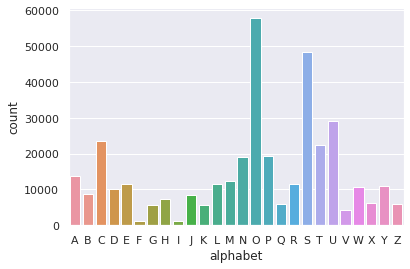

In [46]:
import seaborn as sns
sns.set_theme(style="darkgrid")
ax = sns.countplot(data = label_alphabets, x='alphabet')

# Creating model